## Arrays

In some languages (e.g. Java), there are two types of arrays --
1. Fixed-length arrays
  - the preallocated memory for the data structure is fixed (does not grow)
  - $O(1)$ indexing, i.e. get an element at an index in constant time
2. Resizable arrays
  - Can grow in size, which is useful if you don't know how many elements you need to store in the array up front
  - Indexing is amortized $O(1)$, but can grow
  
#### Huh? What does "amortized" mean?

A resizable array is made from a fixed-length array. Most of the time, we can add elements to the underlying fixed-length array in constant time. However, sometimes, this underlying fixed-length array gets full. When this happens, we make a new fixed-length array of 2x (or some other factor) the size and copy all the elements over. Although copying the elements is slow, i.e. linear time $O(n)$, it can be shown that hitting capacity happens rarely enough that adding elements to the resizable array is still $O(1)$ on average.

In Python, all `list` instances are resizable arrays. As an exercise in understanding/implementing a resizable array, let's pretend we don't have access to a `list`. Although this is a bit kludgy, can use `numpy.empty` to make a fixed size array.

In [117]:
import numpy as np


class ArrayIndexOutOfBoundsException(Exception):
    def __init__(self, idx, size):
        message = "Index {} is outside the array of size {}".format(idx, size)
        super(ArrayIndexOutOfBoundsException, self).__init__(message)

        
class ResizableArray:
    INITIAL_ALLOCATION = 8
    RESIZE_FACTOR = 2
    
    def __init__(self):
        self.allocation = ResizableArray.INITIAL_ALLOCATION
        self.items = np.empty(self.allocation, dtype=object)
        self.size = 0
    
    @classmethod
    def RESIZE_FXN(cls, allocation):
        return allocation * cls.RESIZE_FACTOR
    
    def insert(self, idx, val):
        if idx < 0 or idx > self.size:
            raise ArrayIndexOutOfBoundsException(idx, self.size)
        self.items[idx] = val
    
    def append(self, val, resize_fxn=None):
        if resize_fxn is None:
            resize_fxn = ResizableArray.RESIZE_FXN
        self.ensure_extra_capacity(resize_fxn)
        self.items[self.size] = val
        self.size += 1
        
    def ensure_extra_capacity(self, resize_fxn):
        if self.size == len(self.items):
            self.allocation = resize_fxn(self.allocation)
            new_items = np.empty(self.allocation, dtype=object)
            new_items[:self.size] = self.items
            self.items = new_items
    
    def get(self, idx):
        if idx < 0 or idx > self.size:
            raise ArrayIndexOutOfBoundsException(idx, self.size)
        return self.items[idx]

In [113]:
import unittest

class TestResizableArray(unittest.TestCase):
    def setUp(self):
        self.resizable_array = ResizableArray()
    
    def test_initial_size(self):
        self.assertEqual(self.resizable_array.size, 0)
        self.assertIsNone(self.resizable_array.get(0))

    def test_get_in_bound(self):
        self.resizable_array.append('a')
        self.assertEqual(self.resizable_array.get(0), 'a')

    def test_get_out_of_bound(self):
        self.assertRaises(ArrayIndexOutOfBoundsException, self.resizable_array.get, 1)
        
    def test_append(self):
        self.resizable_array.append('a')
        self.assertEqual(self.resizable_array.get(0), 'a')
        self.assertEqual(self.resizable_array.size, 1)
    
    def test_insert(self):
        self.resizable_array.insert(0, 'b')
        self.assertEqual(self.resizable_array.get(0), 'b')

    def test_ensure_extra_capacity(self):
        for i in range(9):
            self.resizable_array.append('a')
        self.assertEqual(self.resizable_array.size, 9)
        self.assertEqual(self.resizable_array.allocation, 16)

if __name__ == '__main__':
    unittest.main(argv=['Ignore first argument'], exit=False)

......
----------------------------------------------------------------------
Ran 6 tests in 0.007s

OK


Below, I've plotted out the time complexity to visualize amortization at work. We can see that elapsed time when doubling the allocation grows linearly, while elapsed time grows linearly on average when we double allocation whenever we hit capacity. We can also see that the latter comes closer to what Python is doing under the hood.

In [141]:
from time import perf_counter

num_of_elements = 40000
linear_resize = lambda allocation: allocation + 8
array_types = [
    {
        'label': 'increase allocation by doubling',
        'array': ResizableArray(),
        'times': np.empty(num_of_elements, dtype=object)
        
    },
    {
        'label': 'increase allocation by constant',
        'array': ResizableArray(),
        'resize_fxn': linear_resize,
        'times': np.empty(num_of_elements, dtype=object)
    },
    {
        'label': "python's built-in list",
        'array': list(),
        'times': np.empty(num_of_elements, dtype=object)
    }
]

for a_t in array_types:
    start = perf_counter()
    for i in range(num_of_elements):
        try:
            a_t['array'].append('test', a_t['resize_fxn'])
        except KeyError:  # raised if "resize_fxn" is missing a missing key
            a_t['array'].append('test')
        a_t['times'][i] = perf_counter() - start

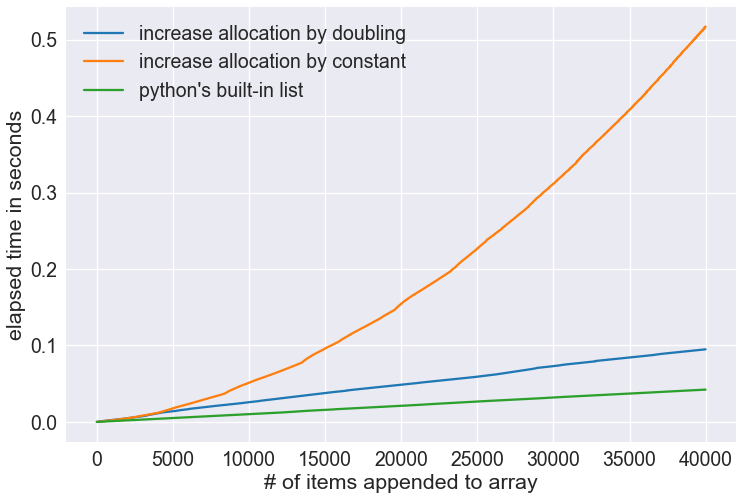

In [142]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk', font_scale=1.5)
sns.set_style('darkgrid') 
plt.rcParams['figure.figsize'] = 12, 8

for a_t in array_types:
    plt.plot(a_t['times'], label=a_t['label'])

plt.legend(loc='best')
plt.xlabel('# of items appended to array')
plt.ylabel('elapsed time in seconds')
plt.show()

Now that I've covered arrays, here's an array problem from CTCI.

A left rotation operation on an array of size $n$ shifts each of the array's elements $1$ unit to the left. For example, if $2$ left rotations are performed on array $\left[1, 2, 3, 4, 5\right]$, then the array would become $\left[3, 4, 5, 1, 2\right]$.

Given an array of $n$ integers and a number, $d$, perform $d$ left rotations on the array. Then print the updated array as a single line of space-separated integers.

In [159]:
# My first attempt
import copy

def array_left_rotation(a, n, k):
    a_cpy = copy.copy(a)  # Copy so that we don't change the array that was passed to this function
    for _ in range(k):
        val_to_move = a_cpy[0]
        for idx in range(n - 1):
            a_cpy[idx] = a_cpy[idx + 1]
        a_cpy[n - 1] = val_to_move
    return a_cpy

In [183]:
# This is faster
def array_left_rotation(a, n, k):
    res = [None] * n
    for idx in range(n):
        res[(idx - k) % n] = a[idx]
    return res

In [184]:
import unittest

class TestArrayLeftRotation(unittest.TestCase):
    def setUp(self):
        self.a = [1, 2, 3, 4, 5]
    
    def test_rotate_once(self):
        self.assertEqual(array_left_rotation(self.a, len(self.a), 1), [2, 3, 4, 5, 1])

    def test_rotate_twice(self):
        self.assertEqual(array_left_rotation(self.a, len(self.a), 2), [3, 4, 5, 1, 2])

    def test_rotate_thrice(self):
        self.assertEqual(array_left_rotation(self.a, len(self.a), 3), [4, 5, 1, 2, 3])

if __name__ == '__main__':
    unittest.main(argv=['Ignore first argument'], exit=False)

.........
----------------------------------------------------------------------
Ran 9 tests in 0.008s

OK


In [167]:
0 % 5

0